# Notebook modèles à base de Transfer Learning

# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import keras

import logging
import tensorflow as tf

# Désactiver une partie des messages d'erreur TF
tf.get_logger().setLevel(logging.ERROR)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
import joblib

# Réimporter la première partie des données
progression_data1 = joblib.load('progression_data1.joblib')
data = progression_data1['data']
data_test = progression_data1['data_test']
list_labels = progression_data1['list_labels']
categ = progression_data1['categ']
label_list = progression_data1['label_list']
X_test = progression_data1['X_test']
y_test = progression_data1['y_test']
X_train = progression_data1['X_train']
X_val = progression_data1['X_val']
y_train = progression_data1['y_train']
y_val = progression_data1['y_val']

# Etape 3 : modèles à base de Transfer Learning
4 approches sont présentées :
* VGG16
* Mobile Net v3s
* Efficient Net v2 B0
* Efficient Net v2 B2

## Création du modèle de classification

# VGG

In [3]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
    predictions = Dense(categ, activation='softmax')(x)   # 4 nombre de categorie

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

In [4]:
# Création du modèle
model2 = create_model_fct()

# Création du callback
model2_save_path2 = "./model/model_vgg16_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Récupére le nombre de paramètres entraînables + non entraînables
model2_nb_params = model2.count_params()


# Entraîner sur les données d'entraînement (X_train, y_train)
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Chargement des poids optimaux
model2.load_weights(model2_save_path2)

loss_v_2, accuracy_v_2 = model2.evaluate(X_val, y_val, verbose=False)
loss_t_2, accuracy_t_2 = model2.evaluate(X_test, y_test, verbose=False)


# Initialisation résultat
results = []

# Ajout de la colonne "Data Augmentation" avec la valeur "sans"
data_augmentation = "sans"

results.append({
            'Model': 'VGG16',
            'Data Augmentation': data_augmentation,
            'Validation Loss Optimal': loss_v_2,
            'Validation Accuracy Optimal': accuracy_v_2,
            'Test Accuracy Optimal': accuracy_t_2,
            'Nombre de paramètres': model2_nb_params
        })

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 1.6099 - accuracy: 0.8194 
Epoch 2: val_loss improved from 0.87053 to 0.86410, saving model to ./model\model_vgg16_best_weights.h5
3/3 [==============================] - 35s 12s/step - loss: 1.6099 - accuracy: 0.8194 - val_loss: 0.8641 - val_accuracy: 0.8958
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.8681 
Epoch 3: val_loss did not improve from 0.86410
3/3 [==============================] - 35s 12s/step - loss: 1.0043 - accuracy: 0.8681 - val_loss: 1.6266 - val_accuracy: 0.7708
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.8333 
Epoch 4: val_loss did not improve from 0.86410
3/3 [==============================] - 35s 12s/step - loss: 1.4067 - accuracy: 0.8333 - val_loss: 0.9591 - val_accuracy: 0.8958
Epoch 5/50
3/3 [==============================] - ETA: 0s - loss: 1.5286 - accuracy: 0.8125 
Epoch 5: val_loss improved from 0.86410 to 0.31373, savin

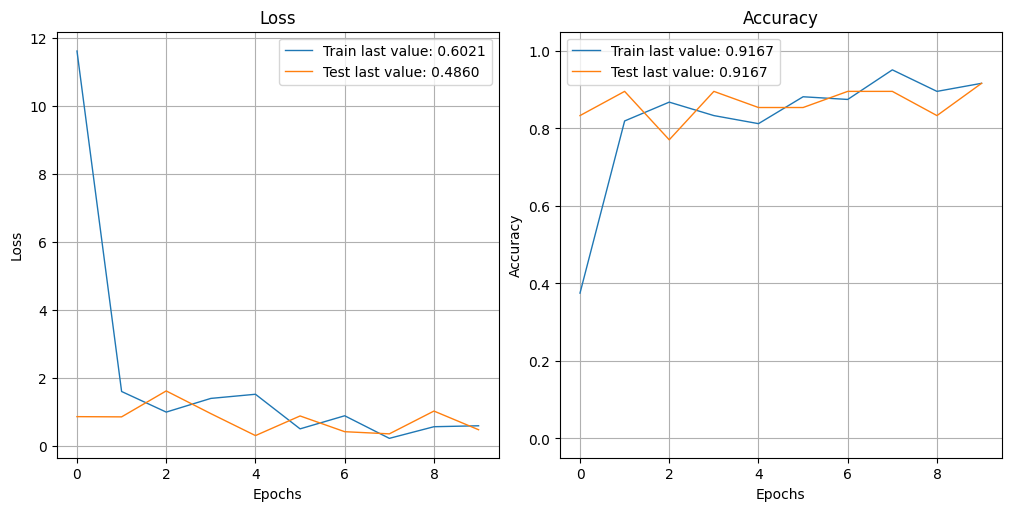

In [5]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="model2.png")
plt.close()

In [6]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model2.predict(X_val), axis=1)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']


y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

print(metrics.classification_report(y_val_num, y_val_pred_transform))

2/2 [==============================] - 9s 3s/step
Correspondance des clusters :  [0 1 2]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        16
           1       0.87      0.81      0.84        16
           2       0.89      1.00      0.94        16

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48



<Axes: >

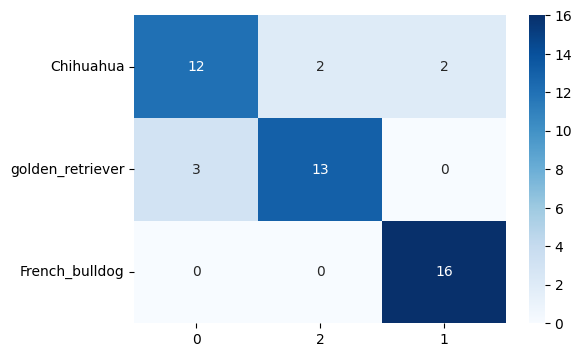

In [7]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in label_list])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

----------------------------------------------------------------------------------------------------------------

# EfficientNetv2

Version B0

In [8]:
def efficientnetv2_model_fct(input_shape=(224, 224, 3), num_classes=categ):
    # Importation d'EfficientNetV2
    import keras
    from keras.applications import EfficientNetV2B0

    # Récupération modèle pré-entraîné
    model = keras.applications.EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape,
        pooling='avg',
        classes=num_classes,  
        classifier_activation="softmax",
        include_preprocessing=True,
    )

    # Retirer la couche supérieure
    x = model.output

    # Ajouter une nouvelle couche de classification avec le nombre de classes spécifié
    predictions = Dense(num_classes, activation='softmax')(x)

    # Créer le modèle final
    model = Model(inputs=model.input, outputs=predictions)

    # Compilation du modèle avec la fonction de perte catégorielle_crossentropy et l'optimiseur RMSprop
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Résumé du modèle
    print(model.summary())

    return model

In [9]:
# Création du modèle EfficientNetV2
model_efficientnetv2 = efficientnetv2_model_fct(num_classes=categ)  # 3 catégories

# Création du callback
model_efficientnetv2_save_path = "./model/model_efficientnetv2b0_best_weights.h5"
checkpoint = ModelCheckpoint(model_efficientnetv2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Récupére le nombre de paramètres 
model_efficientnetv2_nb_params = model_efficientnetv2.count_params()

# Entraîner sur les données d'entraînement (X_train, y_train)
history3 = model_efficientnetv2.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Chargement des poids optimaux
model_efficientnetv2.load_weights(model_efficientnetv2_save_path)

loss_v_3, accuracy_v_3 = model_efficientnetv2.evaluate(X_val, y_val, verbose=False)
loss_t_3, accuracy_t_3 = model_efficientnetv2.evaluate(X_test, y_test, verbose=False)


# Ajout de la colonne "Data Augmentation" avec la valeur "sans"
data_augmentation = "sans"

results.append({
            'Model': 'Efficient Net v2 B0',
            'Data Augmentation': data_augmentation,
            'Validation Loss Optimal': loss_v_3,
            'Validation Accuracy Optimal': accuracy_v_3,
            'Test Accuracy Optimal': accuracy_t_3,
            'Nombre de paramètres': model_efficientnetv2_nb_params
        })

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]'] 

c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 83s 10s/step - loss: 0.8318 - accuracy: 0.6250 - val_loss: 1.1120 - val_accuracy: 0.6250
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9722
Epoch 2: val_loss improved from 1.11203 to 0.24390, saving model to ./model\model_efficientnetv2b0_best_weights.h5
3/3 [==============================] - 19s 6s/step - loss: 0.1687 - accuracy: 0.9722 - val_loss: 0.2439 - val_accuracy: 0.8958
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.24390 to 0.16933, saving model to ./model\model_efficientnetv2b0_best_weights.h5
3/3 [==============================] - 16s 4s/step - loss: 0.0386 - accuracy: 1.0000 - val_loss: 0.1693 - val_accuracy: 0.9167
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 1.0000
Epoch 4: val_loss improved from 0.16933 to 0.12588, saving model to ./model\model_efficientnetv2b0_best_weights.

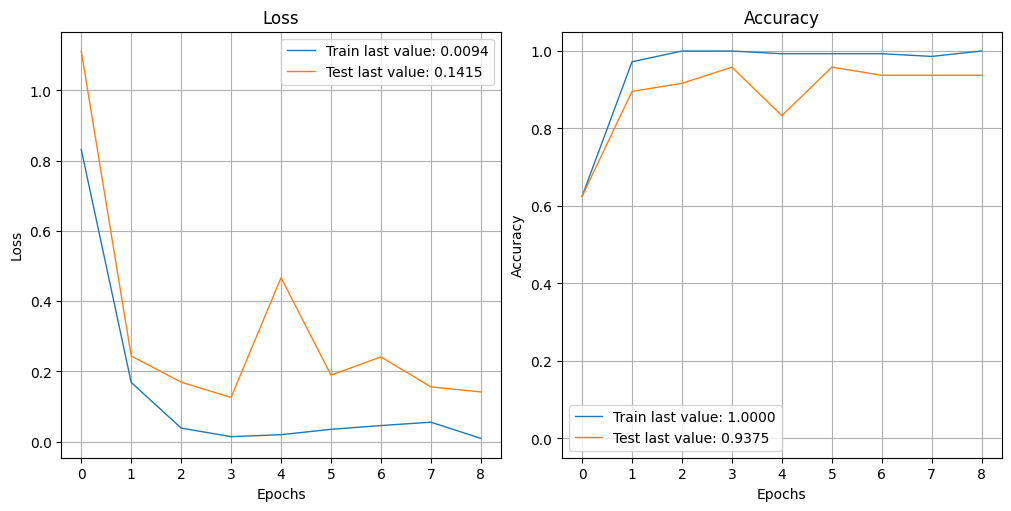

In [10]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="model_ENv2B0.png")
plt.close()

In [11]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model_efficientnetv2.predict(X_val), axis=1)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

print(metrics.classification_report(y_val_num, y_val_pred_transform))

2/2 [==============================] - 4s 296ms/step
Correspondance des clusters :  [0 1 2]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.94      0.94      0.94        16
           2       1.00      1.00      1.00        16

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



<Axes: >

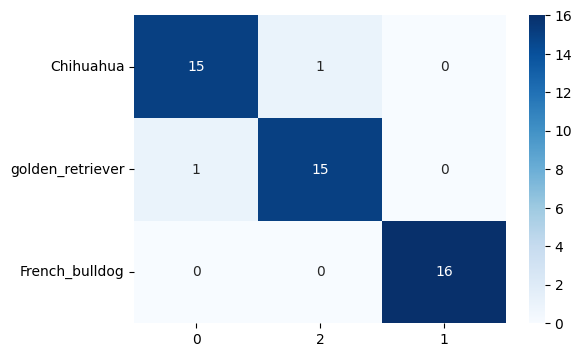

In [12]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in label_list])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

------------------------------------------------------------------------------------------------------------------

# EfficientNetv2

Version B2

In [13]:
def efficientnetv2_b2_model_fct(input_shape=(224, 224, 3), num_classes=categ):
    # Importation d'EfficientNetV2
    from keras.applications import EfficientNetV2B2

    # Récupération modèle pré-entraîné
    model = keras.applications.EfficientNetV2B2(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape,
        pooling='avg',
        classes=num_classes,  
        classifier_activation="softmax",
        include_preprocessing=True,
    )

    # Retirer la couche supérieure
    x = model.output

    # Ajouter une nouvelle couche de classification avec le nombre de classes spécifié
    predictions = Dense(num_classes, activation='softmax')(x)

    # Créer le modèle final
    model = Model(inputs=model.input, outputs=predictions)

    # Compilation du modèle avec la fonction de perte catégorielle_crossentropy et l'optimiseur RMSprop
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Résumé du modèle
    print(model.summary())

    return model

In [14]:
# Création du modèle EfficientNetV2
model_efficientnetv2_b2 = efficientnetv2_b2_model_fct(num_classes=categ)  # 3 catégories

# Création du callback
model_efficientnetv2_b2_save_path = "./model/model_efficientnetv2_b2_best_weights.h5"
checkpoint = ModelCheckpoint(model_efficientnetv2_b2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Récupére le nombre de paramètres 
model_efficientnetv2_b2_nb_params = model_efficientnetv2_b2.count_params()

# Entraîner sur les données d'entraînement (X_train, y_train)
history4 = model_efficientnetv2_b2.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Chargement des poids optimaux
model_efficientnetv2_b2.load_weights(model_efficientnetv2_b2_save_path)

loss_v_4, accuracy_v_4 = model_efficientnetv2_b2.evaluate(X_val, y_val, verbose=False)
loss_t_4, accuracy_t_4 = model_efficientnetv2_b2.evaluate(X_test, y_test, verbose=False)


# Ajout de la colonne "Data Augmentation" avec la valeur "sans"
data_augmentation = "sans"

results.append({
            'Model': 'Efficient Net v2 B2',
            'Data Augmentation': data_augmentation,
            'Validation Loss Optimal': loss_v_4,
            'Validation Accuracy Optimal': accuracy_v_4,
            'Test Accuracy Optimal': accuracy_t_4,
            'Nombre de paramètres': model_efficientnetv2_b2_nb_params
        })

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization_1[0][0]'

c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 111s 23s/step - loss: 0.7959 - accuracy: 0.6250 - val_loss: 0.6138 - val_accuracy: 0.7917
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9722 
Epoch 2: val_loss improved from 0.61381 to 0.43619, saving model to ./model\model_efficientnetv2_b2_best_weights.h5
3/3 [==============================] - 97s 25s/step - loss: 0.1238 - accuracy: 0.9722 - val_loss: 0.4362 - val_accuracy: 0.8125
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9931 
Epoch 3: val_loss did not improve from 0.43619
3/3 [==============================] - 94s 29s/step - loss: 0.0408 - accuracy: 0.9931 - val_loss: 0.5361 - val_accuracy: 0.8125
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000 
Epoch 4: val_loss improved from 0.43619 to 0.26306, saving model to ./model\model_efficientnetv2_b2_best_weights.h5
3/3 [==============================] - 80s 24s/step - los

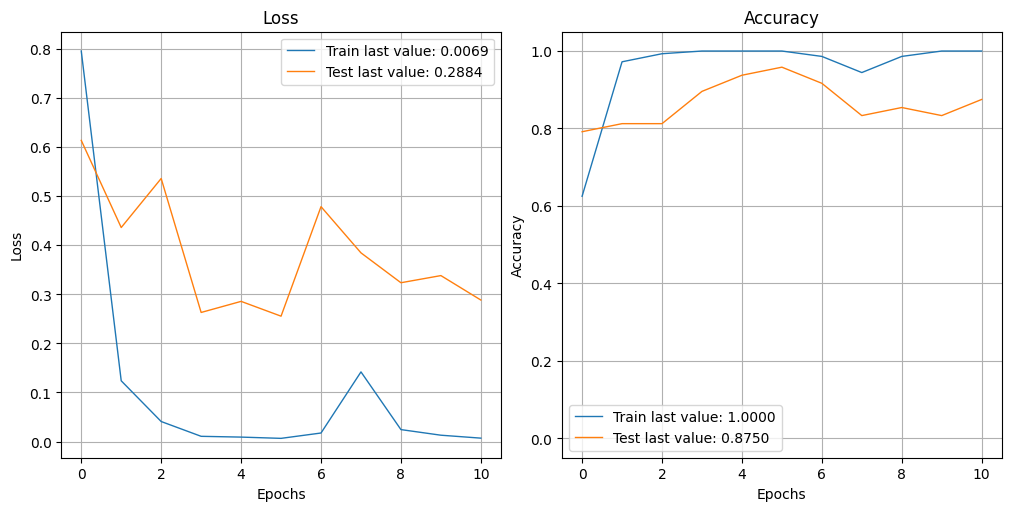

In [15]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="model_ENv2B2.png")
plt.close()

In [16]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model_efficientnetv2_b2.predict(X_val), axis=1)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(metrics.classification_report(y_val_num, y_val_pred_transform))

2/2 [==============================] - 6s 538ms/step
Correspondance des clusters :  [0 1 2]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.94      1.00      0.97        16
           2       1.00      0.94      0.97        16

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



<Axes: >

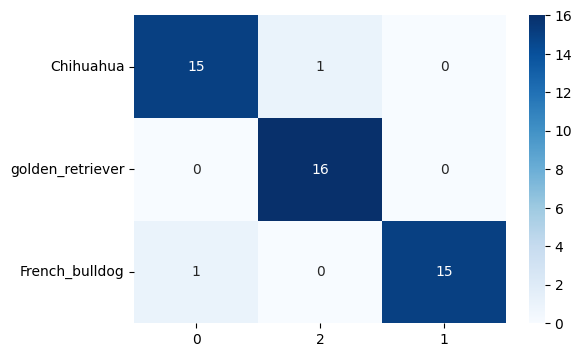

In [17]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in label_list])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

------------------------------------------------------------------------------------------------------------------------------

# MobileNetV3

In [18]:
def mobilenetv3s_model_fct(input_shape=(224, 224, 3), num_classes=categ):
    # Importation de mobilenet
    from keras.applications import MobileNet

    # Récupération modèle pré-entraîné
    model = keras.applications.MobileNetV3Small(
    input_shape=None,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.5,
    classifier_activation="softmax",
    include_preprocessing=True,
)

    # Retirer la couche supérieure
    x = model.output

    # Ajouter une nouvelle couche de classification avec le nombre de classes spécifié
    predictions = Dense(num_classes, activation='softmax')(x)

    # Créer le modèle final
    model = Model(inputs=model.input, outputs=predictions)

    # Compilation du modèle avec la fonction de perte catégorielle_crossentropy et l'optimiseur RMSprop
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Résumé du modèle
    print(model.summary())

    return model

In [19]:
# Création du modèle EfficientNetV2
model_mobilenetv3s = mobilenetv3s_model_fct(num_classes=categ)  # 3 catégories

# Création du callback
model_mobilenetv3s_save_path = "./model/model_mobilenetv3s_best_weights.h5"
checkpoint = ModelCheckpoint(model_mobilenetv3s_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Récupére le nombre de paramètres 
model_mobilenetv3s_nb_params = model_mobilenetv3s.count_params()

# Entraîner sur les données d'entraînement (X_train, y_train)
history5 = model_mobilenetv3s.fit(X_train, y_train, epochs=20, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Chargement des poids optimaux
model_mobilenetv3s.load_weights(model_mobilenetv3s_save_path)

loss_v_5, accuracy_v_5 = model_mobilenetv3s.evaluate(X_val, y_val, verbose=False)
loss_t_5, accuracy_t_5 = model_mobilenetv3s.evaluate(X_test, y_test, verbose=False)


# Ajout de la colonne "Data Augmentation" avec la valeur "sans"
data_augmentation = "sans"

results.append({
            'Model': 'Mobile Net v3s',
            'Data Augmentation': data_augmentation,
            'Validation Loss Optimal': loss_v_5,
            'Validation Accuracy Optimal': accuracy_v_5,
            'Test Accuracy Optimal': accuracy_t_5,
            'Nombre de paramètres': model_mobilenetv3s_nb_params
        })


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, None, None, 16)       432       ['rescaling_2[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, None, None, 16)       64        ['Conv[0][0]']                
 lization)                                                                                  

c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 25s 4s/step - loss: 1.0976 - accuracy: 0.3333 - val_loss: 1.0863 - val_accuracy: 0.6250
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 1.0953 - accuracy: 0.4514
Epoch 2: val_loss improved from 1.08627 to 1.07315, saving model to ./model\model_mobilenetv3s_best_weights.h5
3/3 [==============================] - 4s 1s/step - loss: 1.0953 - accuracy: 0.4514 - val_loss: 1.0732 - val_accuracy: 0.6250
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 1.0864 - accuracy: 0.5486
Epoch 3: val_loss improved from 1.07315 to 1.07102, saving model to ./model\model_mobilenetv3s_best_weights.h5
3/3 [==============================] - 5s 2s/step - loss: 1.0864 - accuracy: 0.5486 - val_loss: 1.0710 - val_accuracy: 0.6458
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 1.0739 - accuracy: 0.5903
Epoch 4: val_loss did not improve from 1.07102
3/3 [==============================] - 3s 1s/step - loss: 1.0739 - accuracy:

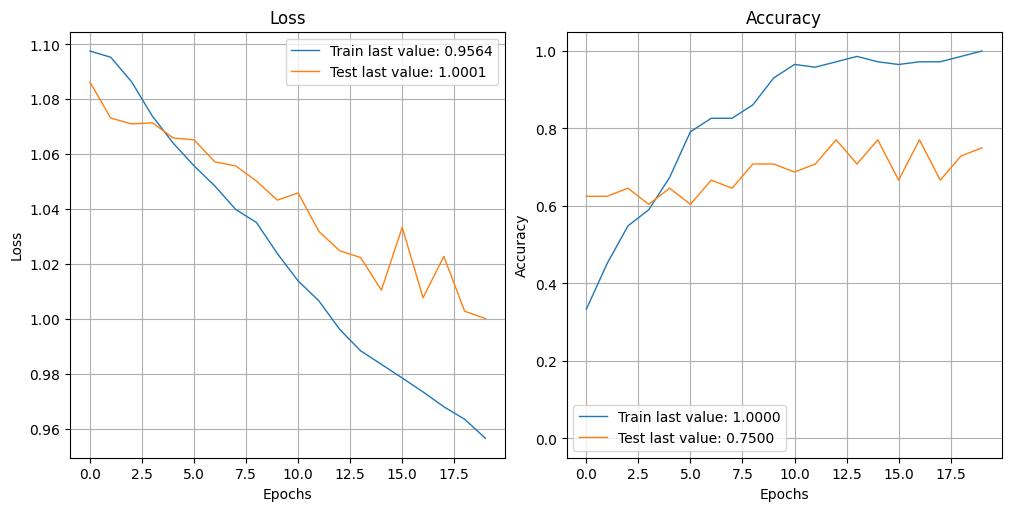

In [20]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history5)
plot_history(history5, path="model_mobilnetv3s.png")
plt.close()

In [21]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model_mobilenetv3s.predict(X_val), axis=1)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(metrics.classification_report(y_val_num, y_val_pred_transform))


2/2 [==============================] - 2s 132ms/step
Correspondance des clusters :  [0 1 2]
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        16
           1       0.73      1.00      0.84        16
           2       0.73      1.00      0.84        16

    accuracy                           0.75        48
   macro avg       0.82      0.75      0.69        48
weighted avg       0.82      0.75      0.69        48



<Axes: >

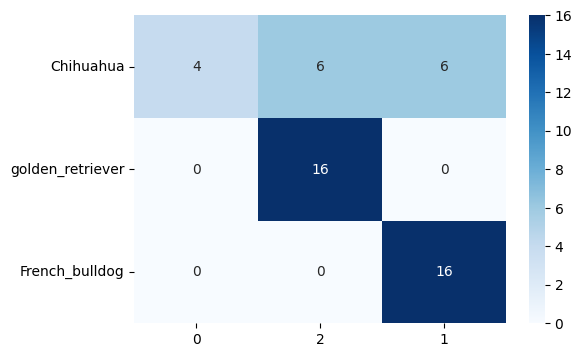

In [22]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in label_list])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle le plus performant: EfficientNetv2B0

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [23]:
# Emplacement des Images
path = "./Images3"
path_test = "./Images3_test"

batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 240 files belonging to 3 classes.
Using 180 files for training.
Found 240 files belonging to 3 classes.
Using 60 files for validation.
Found 60 files belonging to 3 classes.


In [24]:
def efficientnetv2_augmentation_model_fct(input_shape=(224, 224, 3), num_classes=categ):
    # Importation d'EfficientNetV2
    import keras
    from keras.applications import EfficientNetV2B0
    from keras.models import Model
    from keras.layers import Dense, Input
    from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

    # Ajout de la data augmentation comme couches de prétraitement
    inputs = Input(shape=input_shape)
    x = RandomFlip("horizontal")(inputs)
    x = RandomRotation(0.1)(x)
    x = RandomZoom(0.1)(x)

    # Récupération modèle pré-entraîné
    base_model = EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_tensor=x,  # Utilisation de la sortie de la data augmentation comme entrée
        input_shape=input_shape,
        pooling='avg',
        classes=num_classes,
        classifier_activation="softmax",
        include_preprocessing=False,  # Désactivation du prétraitement intégré
    )

    # Ajout d'une nouvelle couche de classification avec le nombre de classes spécifié
    predictions = Dense(num_classes, activation='softmax')(base_model.output)

    # Création du modèle final
    model = Model(inputs=inputs, outputs=predictions)

    # Compilation du modèle avec la fonction de perte catégorielle_crossentropy et l'optimiseur RMSprop
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Résumé du modèle
    print(model.summary())

    return model

In [25]:
# Création du modèle
model_effnet_aug = efficientnetv2_augmentation_model_fct()

# Création du callback
model_effnet_aug_save_path = "./model/model_efficientnetv2b0_augmentation_best_weights.h5"
checkpoint = ModelCheckpoint(model_effnet_aug_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Récupére le nombre de paramètres 
model4_nb_params = model_effnet_aug.count_params()

# Entraînement du modèle
history6 = model_effnet_aug.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

# Chargement des poids optimaux
model_effnet_aug.load_weights(model_effnet_aug_save_path)

loss_v_6, accuracy_v_6 = model_effnet_aug.evaluate(dataset_val, verbose=False)
loss_t_6, accuracy_t_6 = model_effnet_aug.evaluate(dataset_test, verbose=False)


# Ajout de la colonne "Data Augmentation" avec la valeur "sans"
data_augmentation = "avec"

results.append({
            'Model': 'Efficient Net v2 B0',
            'Data Augmentation': data_augmentation,
            'Validation Loss Optimal': loss_v_6,
            'Validation Accuracy Optimal': accuracy_v_6,
            'Test Accuracy Optimal': accuracy_t_6,
            'Nombre de paramètres': model4_nb_params
        })

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 random_flip (RandomFlip)    (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 random_rotation (RandomRot  (None, 224, 224, 3)          0         ['random_flip[0][0]']         
 ation)                                                                                           
                                                                                                  
 random_zoom (RandomZoom)    (None, 224, 224, 3)          0         ['random_rotation[0][0]'

c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 48s 4s/step - loss: 0.5753 - accuracy: 0.7611 - val_loss: 0.5569 - val_accuracy: 0.8000
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9333
Epoch 2: val_loss improved from 0.55688 to 0.21039, saving model to ./model\model_efficientnetv2b0_augmentation_best_weights.h5
6/6 [==============================] - 17s 3s/step - loss: 0.2045 - accuracy: 0.9333 - val_loss: 0.2104 - val_accuracy: 0.9167
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9444
Epoch 3: val_loss did not improve from 0.21039
6/6 [==============================] - 16s 3s/step - loss: 0.1690 - accuracy: 0.9444 - val_loss: 0.3902 - val_accuracy: 0.9000
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9611
Epoch 4: val_loss did not improve from 0.21039
6/6 [==============================] - 16s 3s/step - loss: 0.0877 - accuracy: 0.9611 - val_loss: 0.7316 - val_accuracy: 0

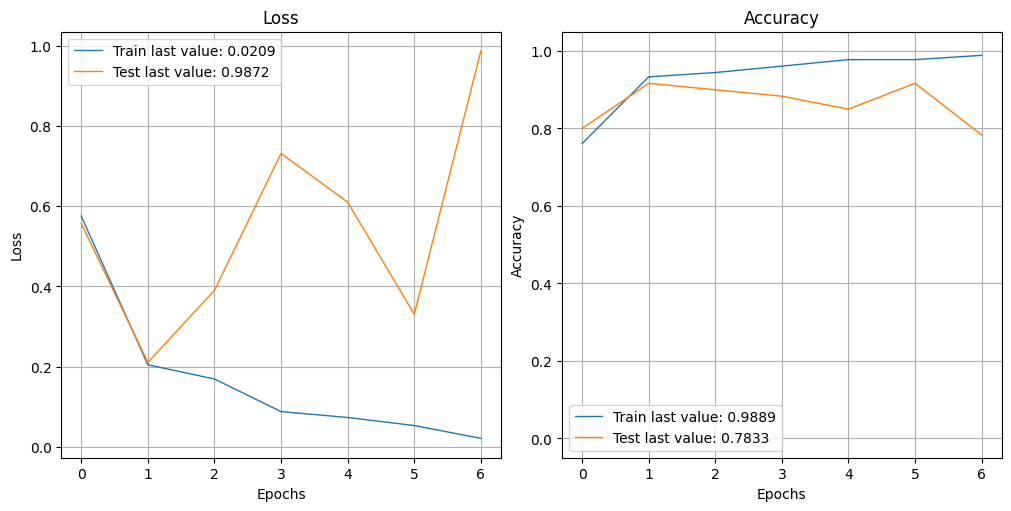

In [26]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history6)
plot_history(history6, path="efficientnetv2b0_augm.png")
plt.close()

# Résultat

In [27]:
results_df = pd.DataFrame(results)
results_df

,Model,Data Augmentation,Validation Loss Optimal,Validation Accuracy Optimal,Test Accuracy Optimal,Nombre de paramètres
0,VGG16,sans,0.313731,0.854167,0.937500,14846787
1,Efficient Net v2 B0,sans,0.125881,0.958333,0.875000,5923155
2,Efficient Net v2 B2,sans,0.255487,0.958333,0.958333,8773601
3,Mobile Net v3s,sans,1.000100,0.750000,0.750000,2557971
4,Efficient Net v2 B0,avec,0.210392,0.916667,0.916667,5923155


In [28]:
# Résultat par ordre croissant sur Test Accuracy Optimal
results_df.sort_values(by='Test Accuracy Optimal')

,Model,Data Augmentation,Validation Loss Optimal,Validation Accuracy Optimal,Test Accuracy Optimal,Nombre de paramètres
3,Mobile Net v3s,sans,1.000100,0.750000,0.750000,2557971
1,Efficient Net v2 B0,sans,0.125881,0.958333,0.875000,5923155
4,Efficient Net v2 B0,avec,0.210392,0.916667,0.916667,5923155
0,VGG16,sans,0.313731,0.854167,0.937500,14846787
2,Efficient Net v2 B2,sans,0.255487,0.958333,0.958333,8773601


In [29]:
# Résultat par ordre croissant sur Validation Accuracy Optimal
results_df.sort_values(by='Validation Accuracy Optimal')

,Model,Data Augmentation,Validation Loss Optimal,Validation Accuracy Optimal,Test Accuracy Optimal,Nombre de paramètres
3,Mobile Net v3s,sans,1.000100,0.750000,0.750000,2557971
0,VGG16,sans,0.313731,0.854167,0.937500,14846787
4,Efficient Net v2 B0,avec,0.210392,0.916667,0.916667,5923155
1,Efficient Net v2 B0,sans,0.125881,0.958333,0.875000,5923155
2,Efficient Net v2 B2,sans,0.255487,0.958333,0.958333,8773601


---------------------------------------------------------------------------

# Efficient Net B0 sur 50 races:

In [2]:
import shutil
from sklearn import preprocessing

# Répertoire contenant les images d'entraînement
data_dir = "./Images9"

# Création du répertoire pour les images de test
test_data_dir = "./Images9_test"
os.makedirs(test_data_dir, exist_ok=True)

# Liste des sous-dossiers (races)
subfolders = os.listdir(data_dir)

# Initialisation des listes pour les chemins des images d'entraînement et de test
path = []
path_test = []

# Parcours de chaque sous-dossier
for subfolder in subfolders:
    # Chemin complet du sous-dossier
    subfolder_path = os.path.join(data_dir, subfolder)
    
    # Création du sous-répertoire de test s'il n'existe pas déjà
    test_subfolder_path = os.path.join(test_data_dir, subfolder)
    if not os.path.exists(test_subfolder_path):
        os.makedirs(test_subfolder_path)
    
    # Chargement des chemins des images dans le sous-dossier
    subfolder_paths = glob(os.path.join(subfolder_path, '*.jpg'))
    
    # Division du sous-dossier en ensembles d'entraînement et de test
    train_paths_sub, test_paths_sub = train_test_split(subfolder_paths, test_size=0.2, random_state=42, stratify=[subfolder]*len(subfolder_paths))
    
    # Déplacement des images de test vers le répertoire de test (si le sous-répertoire est vide)
    if not os.listdir(test_subfolder_path):
        for test_path in test_paths_sub:
            shutil.move(test_path, test_subfolder_path)
    
    # Ajout des chemins d'entraînement et de test aux listes correspondantes
    path.extend(train_paths_sub)
    path_test.extend(test_paths_sub)

# Création des DataFrames pour les données d'entraînement et de test
data = pd.DataFrame({"image_path": path})
data_test = pd.DataFrame({"image_path": path_test})

# Liste des races de chiens dans le Stanford Dogs Dataset
list_labels_dogs = os.listdir(data_dir)

# Fonction pour extraire la race à partir du chemin de l'image
def dog_breed_from_path(photo_path):
    for label in list_labels_dogs:
        if label in photo_path:
            return label.split('-')[-1]
    return "no_breed"

data["label_name"] = data["image_path"].apply(dog_breed_from_path)
data_test["label_name"] = data_test["image_path"].apply(dog_breed_from_path)

# Instanciation de l'encodeur de labels
le = preprocessing.LabelEncoder()

# Adapter l'encodeur de labels aux données d'entraînement
le.fit(data["label_name"])

# Appliquer l'encodeur de labels aux données d'entraînement
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])

# Liste nom de chien unique
list_labels = data.label_name.unique()
list_labels_test = data_test.label_name.unique()

# Nombre de race de chien
categ = len(list_labels)
categ_test = len(list_labels_test)

# Liste des labels
label_list = data.label.unique()
label_list_test = data_test.label.unique()

# Affichage des premières lignes des DataFrames
print(data.head())
print(data_test.head())

                                         image_path label_name  label
0  ./Images9\n02085620-Chihuahua\n02085620_2937.jpg  Chihuahua      7
1   ./Images9\n02085620-Chihuahua\n02085620_275.jpg  Chihuahua      7
2  ./Images9\n02085620-Chihuahua\n02085620_2815.jpg  Chihuahua      7
3  ./Images9\n02085620-Chihuahua\n02085620_3110.jpg  Chihuahua      7
4  ./Images9\n02085620-Chihuahua\n02085620_8585.jpg  Chihuahua      7
                                         image_path label_name  label
0  ./Images9\n02085620-Chihuahua\n02085620_1492.jpg  Chihuahua      7
1     ./Images9\n02085620-Chihuahua\n02085620_7.jpg  Chihuahua      7
2  ./Images9\n02085620-Chihuahua\n02085620_8637.jpg  Chihuahua      7
3  ./Images9\n02085620-Chihuahua\n02085620_3875.jpg  Chihuahua      7
4  ./Images9\n02085620-Chihuahua\n02085620_1617.jpg  Chihuahua      7


In [3]:
# Affichez les tailles des ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(data))
print("Taille de l'ensemble de test :", len(data_test))

# Affichez le nombre unique de races dans chaque ensemble
print("Nombre de races uniques dans l'ensemble d'entraînement :", data["label_name"].nunique())
print("Nombre de races uniques dans l'ensemble de test :", data_test["label_name"].nunique())

# Affichez les premières lignes du DataFrame des données d'entraînement
data.head(5)

Taille de l'ensemble d'entraînement : 4498
Taille de l'ensemble de test : 1150
Nombre de races uniques dans l'ensemble d'entraînement : 50
Nombre de races uniques dans l'ensemble de test : 50


,image_path,label_name,label
0,./Images9\n02085620-Chihuahua\n02085620_2937.jpg,Chihuahua,7
1,./Images9\n02085620-Chihuahua\n02085620_275.jpg,Chihuahua,7
2,./Images9\n02085620-Chihuahua\n02085620_2815.jpg,Chihuahua,7
3,./Images9\n02085620-Chihuahua\n02085620_3110.jpg,Chihuahua,7
4,./Images9\n02085620-Chihuahua\n02085620_8585.jpg,Chihuahua,7


In [6]:
import joblib

# Récupére les label_name uniques
unique_labels = data["label_name"].unique()

# Dictionnaire pour stocker les labels associés à chaque label_name unique
label_dict = {}

# Parcour les label_name uniques
for label in unique_labels:
    # Trouve le label associé à label_name dans les données
    label_value = data[data["label_name"] == label]["label"].iloc[0]
    # Ajoute l'entrée au dictionnaire
    label_dict[label] = label_value

# Enregistrement
joblib.dump(label_dict, "label_dict.joblib")

['label_dict.joblib']

In [7]:
data.groupby("label").count()

,image_path,label_name
label,,
0,102,102
1,83,83
2,99,99
3,92,92
4,87,87
5,92,92
6,84,84
7,76,76
8,92,92


In [8]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

unique_labels = data["label_name"].unique()

for label in unique_labels:
    list_name = f"list_{label.lower().replace(' ', '_')}"
    globals()[list_name] = list_fct(label)

    print(list_name)

list_chihuahua
list_basset
list_beagle
list_bloodhound
list_bluetick
list_tan_coonhound
list_walker_hound
list_english_foxhound
list_redbone
list_borzoi
list_irish_wolfhound
list_italian_greyhound
list_whippet
list_ibizan_hound
list_norwegian_elkhound
list_otterhound
list_saluki
list_scottish_deerhound
list_weimaraner
list_staffordshire_bullterrier
list_american_staffordshire_terrier
list_bedlington_terrier
list_border_terrier
list_kerry_blue_terrier
list_irish_terrier
list_norfolk_terrier
list_norwich_terrier
list_yorkshire_terrier
list_haired_fox_terrier
list_lakeland_terrier
list_sealyham_terrier
list_airedale
list_cairn
list_australian_terrier
list_dandie_dinmont
list_boston_bull
list_miniature_schnauzer
list_giant_schnauzer
list_standard_schnauzer
list_scotch_terrier
list_tibetan_terrier
list_silky_terrier
list_coated_wheaten_terrier
list_west_highland_white_terrier
list_lhasa
list_coated_retriever
list_golden_retriever
list_labrador_retriever
list_chesapeake_bay_retriever
list_ha

In [9]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
images_features = []
i=0
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400


(4498, 4096)

In [11]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(4498, 4096)
(4498, 2223)


In [12]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            66.16 secondes


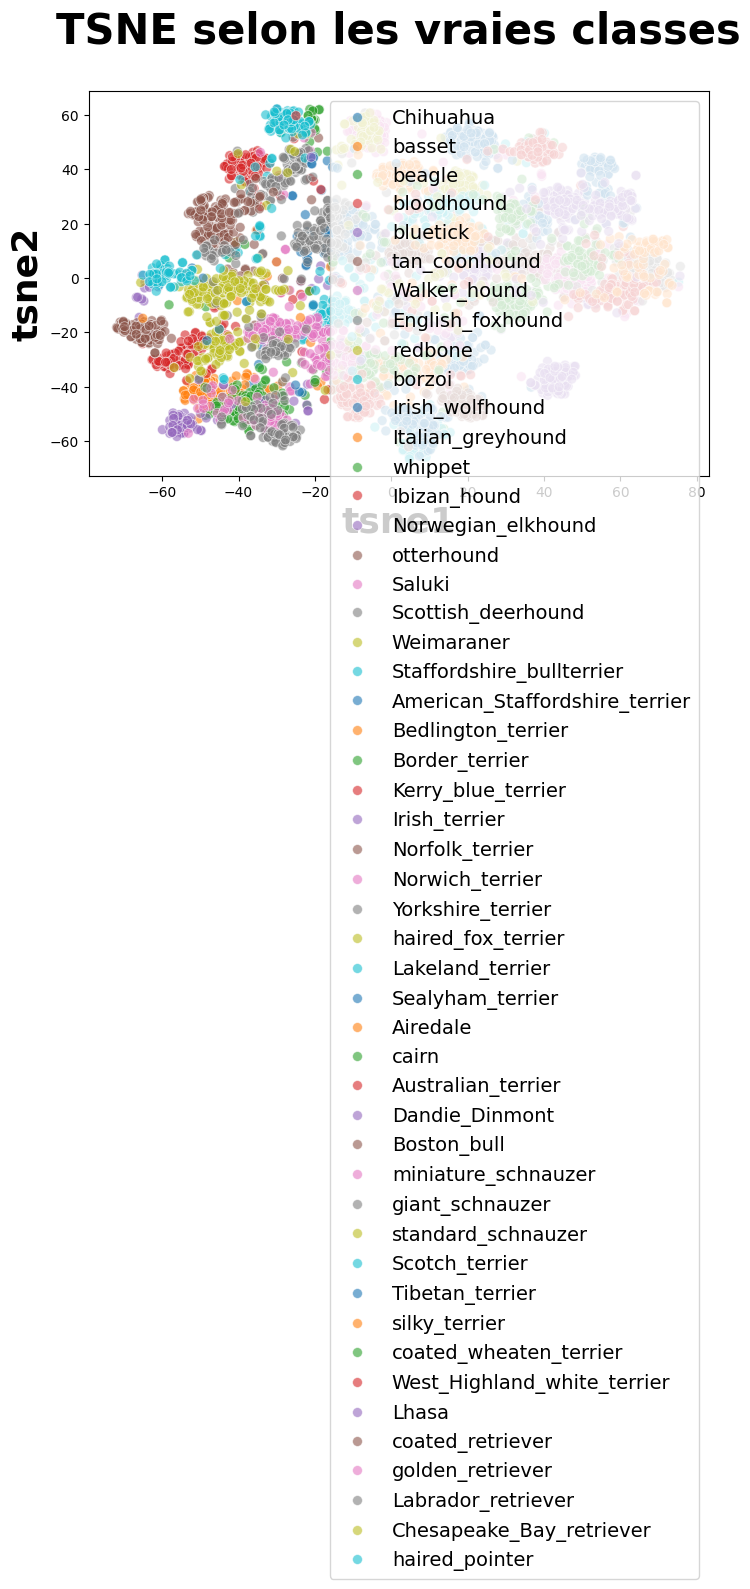

In [13]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=50), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

In [14]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=50, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=50, n_init=100)

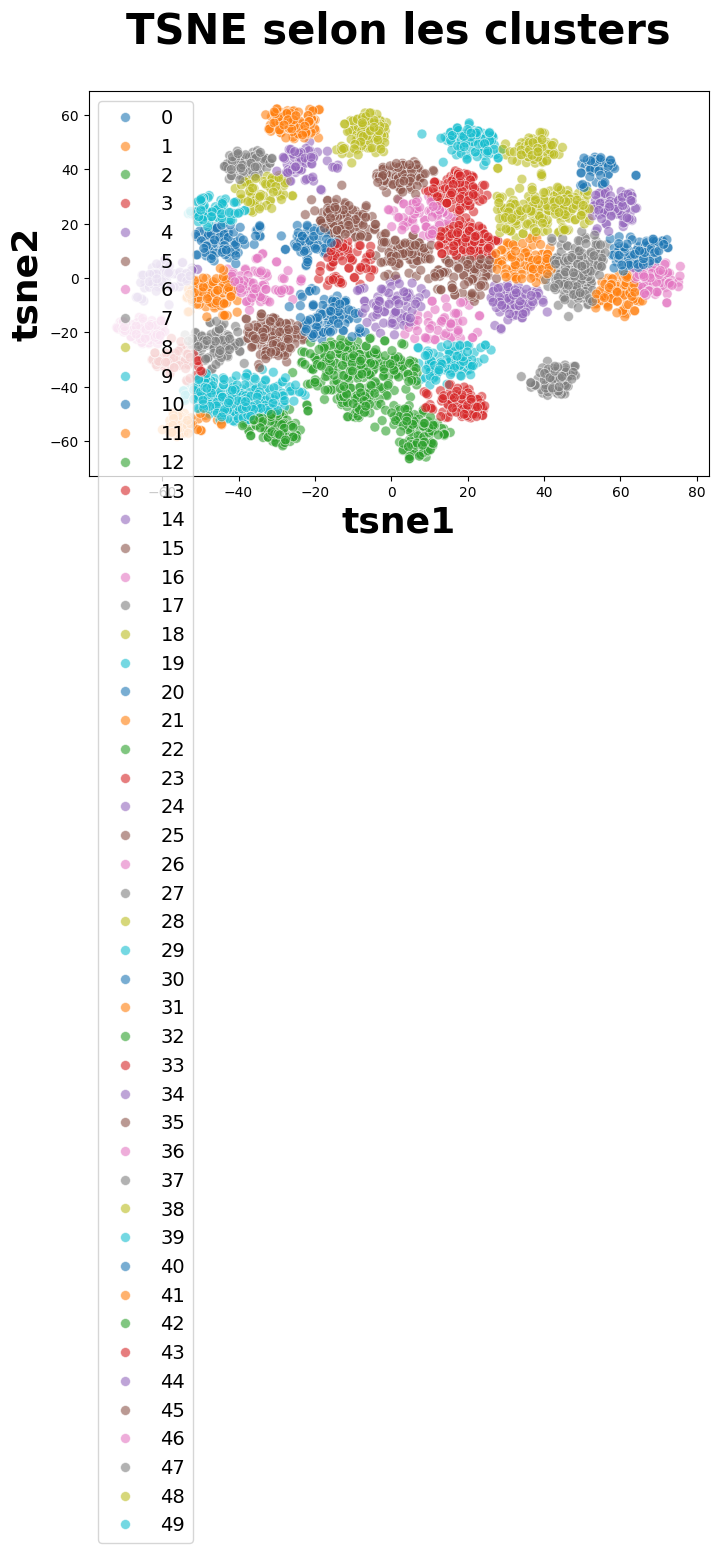

ARI :  0.46535209290063884


In [15]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=50), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Approche préparation des images

In [16]:
# Prétraitement des images
def image_prep_fct(data):
    prepared_images = []
    data_reset_index = data.reset_index(drop=True)  # Réinitialiser l'index
    for image_num in range(len(data_reset_index['image_path'])):
        img = (load_img(
            data_reset_index['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data)
print(images_np.shape)

images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(4498, 224, 224, 3)
(1150, 224, 224, 3)


In [17]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(3373, 224, 224, 3)

---------------------------------------------

# EfficientNetV2B0

In [19]:
def efficientnetv2_model_fct(input_shape=(224, 224, 3), num_classes=50):
    # Importation d'EfficientNetV2
    import keras
    from keras.applications import EfficientNetV2B0

    # Récupération modèle pré-entraîné
    model = keras.applications.EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape,
        pooling='avg',
        classes=num_classes,  
        classifier_activation="softmax",
        include_preprocessing=True,
    )

    # Retirer la couche supérieure
    x = model.output

    # Ajouter une nouvelle couche de classification avec le nombre de classes spécifié
    predictions = Dense(num_classes, activation='softmax')(x)

    # Créer le modèle final
    model = Model(inputs=model.input, outputs=predictions)

    # Compilation du modèle avec la fonction de perte catégorielle_crossentropy et l'optimiseur RMSprop
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Résumé du modèle
    print(model.summary())

    return model

In [20]:
# Création du modèle EfficientNetV2
model_efficientnetv2 = efficientnetv2_model_fct(num_classes=50)  # 3 catégories

# Création du callback
model_efficientnetv2_save_path = "./model/model_efficientnetv2b0_50races_best_weights.h5"
checkpoint = ModelCheckpoint(model_efficientnetv2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Récupére le nombre de paramètres 
model_efficientnetv2_nb_params = model_efficientnetv2.count_params()

# Entraîner sur les données d'entraînement (X_train, y_train)
history3 = model_efficientnetv2.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Chargement des poids optimaux
model_efficientnetv2.load_weights(model_efficientnetv2_save_path)

loss_v_3, accuracy_v_3 = model_efficientnetv2.evaluate(X_val, y_val, verbose=False)
loss_t_3, accuracy_t_3 = model_efficientnetv2.evaluate(X_test, y_test, verbose=False)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]'] 

c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 365s 6s/step - loss: 1.8660 - accuracy: 0.5007 - val_loss: 1.1539 - val_accuracy: 0.6382
Epoch 2/50
53/53 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.8002
Epoch 2: val_loss did not improve from 1.15386
53/53 [==============================] - 361s 7s/step - loss: 0.6580 - accuracy: 0.8002 - val_loss: 1.2354 - val_accuracy: 0.6089
Epoch 3/50
53/53 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.9117
Epoch 3: val_loss did not improve from 1.15386
53/53 [==============================] - 338s 6s/step - loss: 0.3136 - accuracy: 0.9117 - val_loss: 1.2765 - val_accuracy: 0.6524
Epoch 4/50
53/53 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9360
Epoch 4: val_loss did not improve from 1.15386
53/53 [==============================] - 343s 6s/step - loss: 0.2231 - accuracy: 0.9360 - val_loss: 1.3053 - val_accuracy: 0.6569
Epoch 5/50
53/53 [==============================] - ETA: 

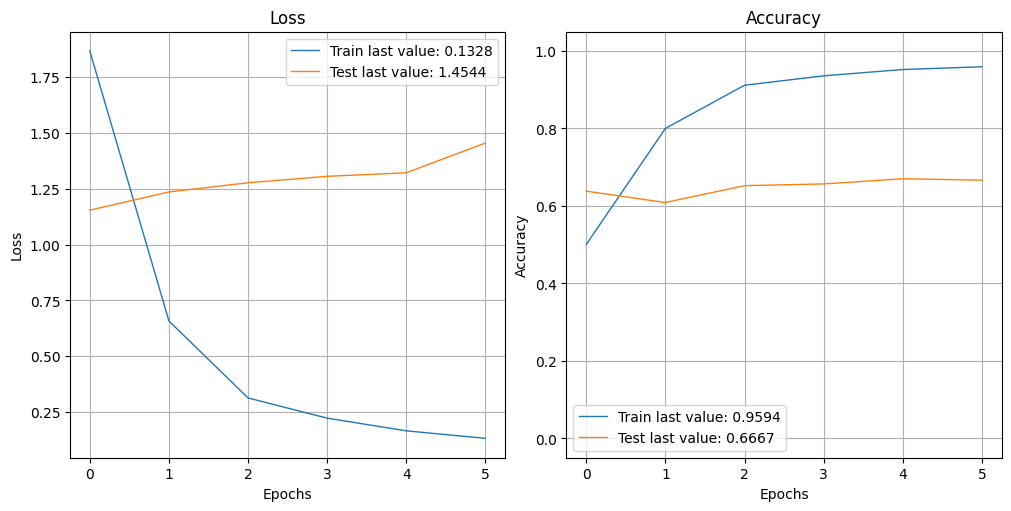

In [21]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="efficientnetv2b0_50races.png")
plt.close()